In [1]:
import context
from numlabs.lab7 import accuracy2d, rain_grace

******************************
context imported. Front of path:
/Users/gracewatts/repos/numeric_2024
back of path: /opt/miniconda3/envs/numeric_2024/lib/python3.12/site-packages
******************************

through /Users/gracewatts/repos/numeric_2024/notebooks/lab7/context.py


# Problem Four

Which grid gives the best accuracy for $d=R/2$?
Explain in what ways it is more accurate.  Consider the accuracy of the frequency, but also the accuracy of the group speed (the gradient of the frequency with respect to wavenumber).  Describe what ranges of wavenumber the accuracy is good and what ranges it is less good.

For grid 1
$$\omega ^2 = f^2 \cos^2(\frac{kd}{2}) + \frac{4gH \sin^2(\frac{kd}{2})}{d^2}$$
Given 
$R = \frac{\sqrt{gH}}{f}$ ==> 
$f = \frac{\sqrt{gH}}{R}$ then,
$$(\frac{\omega}{f}) ^2 = \cos^2(\frac{kd}{2}) + \frac{4 \sin^2(\frac{kd}{2})}{(d/R)^2}$$

And for grid 2
$$\omega ^2 = f^2  + \frac{4gH \sin^2(\frac{kd}{2})}{d^2}$$
becomes,
$$(\frac{\omega}{f}) ^2 = 1  + \frac{4 \sin^2(\frac{kd}{2})}{(d/R)^2}$$

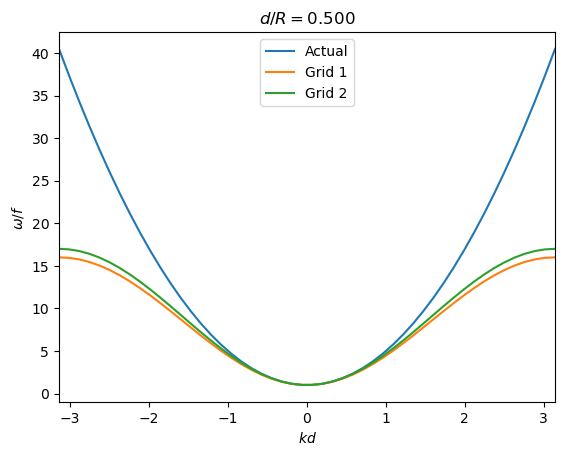

In [2]:
accuracy2d.main(0.5)

The figure above shows both grids having pretty accurate frequencies between -1 and 1 kd. Outside -1 and 1 the curves representing the grids start to diverge from eachother and the Actual curve, but grid 2 is slightly closer. The group speeds of the Grid curves outside of -1 and 1 are smaller than then that of the Actual curve and at the axis limit, the Grid group speeds go to zero when the actual goes to inf. Between -1 and 1, the group speeds of all the curves match up and go to zero in the middle of the grid.

So, given that the Grid 2 curve diverges less than the Grid 1 curve from the Actual curve it is more accurate, and particularly at small wavenumbers. 

# Problem Five

Modify *rain.py* to solve equations
(No variation in y, first eqn), (No variation in y, second eqn) and (No variation in y, third eqn) on the most accurate
grid.

(No variation in y, first eqn)
$$\frac{\partial u}{\partial t} - fv = -g\frac{\partial h}{\partial x}$$ 

(No variation in y, second eqn)
$$\frac{\partial v}{\partial t} + fu = 0$$

(No variation in y, third eqn)
$$\frac{\partial h}{\partial t} + H\frac{\partial u}{\partial x} = 0$$

The discretized equations look like,

(Staggered, first eqn)
$$\frac {u_{i}(t+dt)-u_{i}(t-dt)}{2 dt} - f * v_{i} = - g \frac {h_{i + 1}(t) - h_{i}(t)}{dx}$$
(Staggered, second eqn)
$$\frac {v_{i}(t+dt)-v_{i}(t-dt)}{2 dt} + f * u_{i} = 0 $$
(Staggered, third eqn)
$$\frac {h_{i}(t+dt)-h_{i}(t-dt)}{2 dt} + H \frac {u_{i}(t) - u_{i - 1}(t)}{dx} = 0$$

Initial Conditions: if h is zero everwhere accept at the $h_{3}$,
$$ h_{3}(0) = h_{0} $$
$$ h_{3}(dt) = h_{3}(0) - h_{0}Hg\frac{dt^2}{dx^2} $$
then velocities are zero except at $u_{2}$, $u_{3}$, $v_{2}$, $v_{3}$,
$$ u_{2}(dt) = -gh_{0}\frac{dt}{dx} + fv_{2}dt $$
$$ u_{3}(dt) = gh_{0}\frac{dt}{dx} + fv_{2}dt $$
$$ v_{2}(dt) = -fu_{2}dt$$
$$ v_{3}(dt) = -fu_{3}dt$$

And Boundary Conditions we assume velocities are zero at the walls $dx$ and $ndx$,
$$ u_{1}(t) = 0 $$
$$ u_{n}(t) = 0 $$
$$ v_{1}(t) = 0 $$
$$ v_{n}(t) = 0 $$

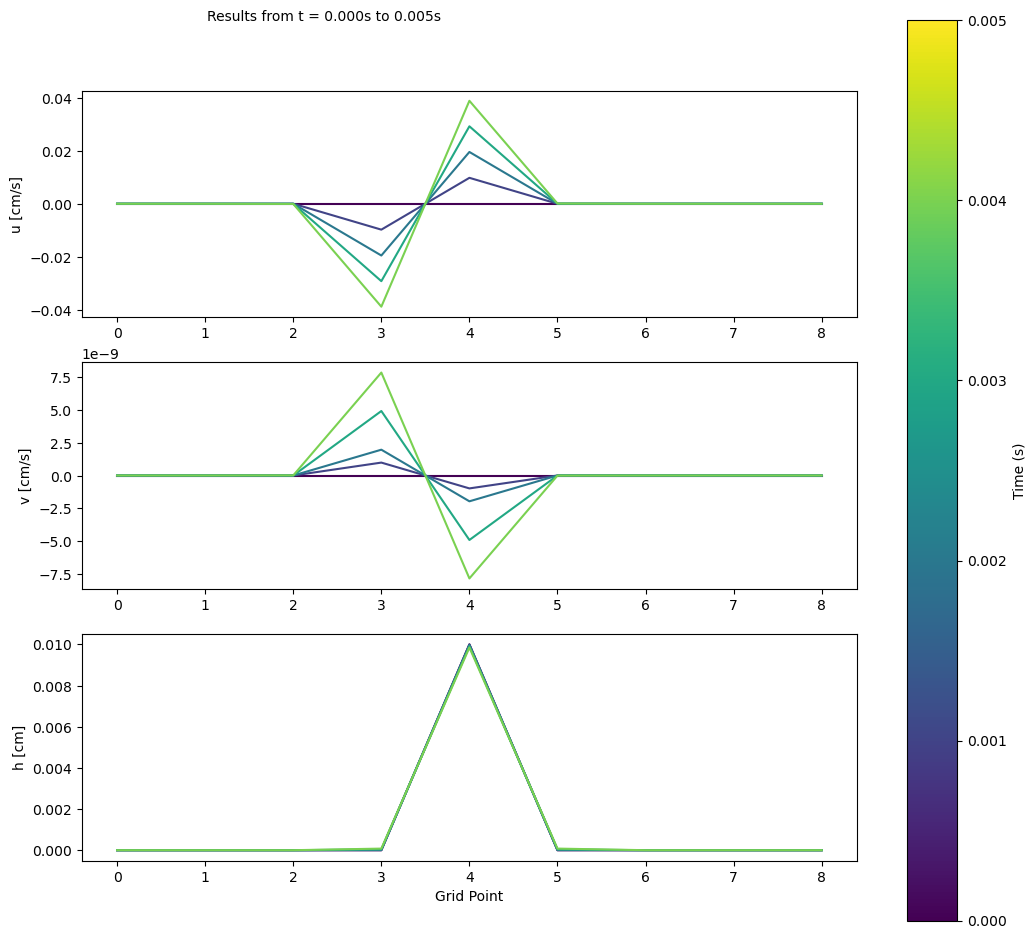

In [2]:
# Run 5 time steps on a 9 point grid
rain_grace.rain([5,9])

Modified rain.py below. There are "G.W." at the line/lines I edited

In [ ]:
#!/usr/bin/env python
"""Calculate the values of surface height (h) and east-west velocity
(u) in a dish of water where a point disturbance of h initiates waves.
Use the simplified shallow water equations on a non-staggered grid.

This is an implementation of lab7 section 4.3.

Example usage from the notebook::

from numlabs.lab7 import rain
# Run 5 time steps on a 9 point grid
rain.rain(5,9)

Example usage from the shell::

  # Run 5 time steps on a 9 point grid
  $ rain.py 5 9

The graph window will close as soon as the animation finishes.  And
the default run for 5 time steps doesn't produce much of interest; try
at least 100 steps.

Example usage from the Python interpreter::

  $ python
  ...
  >>> import rain
  >>> # Run 200 time steps on a 9 point grid
  >>> rain.rain((200, 9))
"""
from __future__ import division
import copy
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colorbar as colorbar
import os,glob

class Quantity(object):
    """Generic quantity to define the data structures and method that
    are used for both u and h.

    u and h objects will be instances of this class.
    """
    def __init__(self, n_grid, n_time):
        """Initialize an object with prev, now, and next arrays of
        n_grid points, and a store array of n_time time steps.
        """
        self.n_grid = n_grid
        # Storage for values at previous, current, and next time step
        self.prev = np.empty(n_grid)
        self.now = np.empty(n_grid)
        self.next = np.empty(n_grid)
        # Storage for results at each time step.  In a bigger model
        # the time step results would be written to disk and read back
        # later for post-processing (such as plotting).
        self.store = np.empty((n_grid, n_time))


    def store_timestep(self, time_step, attr='next'):
        """Copy the values for the specified time step to the storage
        array.

        The `attr` argument is the name of the attribute array (prev,
        now, or next) that we are going to store.  Assigning the value
        'next' to it in the function def statement makes that the
        default, chosen because that is the most common use (in the
        time step loop).
        """
        # The __getattribute__ method let us access the attribute
        # using its name in string form;
        # i.e. x.__getattribute__('foo') is the same as x.foo, but the
        # former lets us change the name of the attribute to operate
        # on at runtime.
        self.store[:, time_step] = self.__getattribute__(attr)


    def shift(self):
        """Copy the .now values to .prev, and the .next values to .new.

        This reduces the storage requirements of the model to 3 n_grid
        long arrays for each quantity, which becomes important as the
        domain size and model complexity increase.  It is possible to
        reduce the storage required to 2 arrays per quantity.
        """
        # Note the use of the copy() method from the copy module in
        # the standard library here to get a copy of the array, not a
        # copy of the reference to it.  This is an important and
        # subtle aspect of the Python data model.
        self.prev = copy.copy(self.now)
        self.now = copy.copy(self.next)

# G.W.
def initial_conditions(u, h, v, ho):
    """Set the initial condition values.
    """
    u.prev[:] = 0
    v.prev[:] = 0
    h.prev[:] = 0
    # defining h_0 to be in the middle of the grid
    h.prev[len(h.prev) // 2] = ho

# G.W. v boundaries are the same as u
def boundary_conditions(u_array, h_array, v_array, n_grid):
    """Set the boundary condition values.
    """
    u_array[0] = 0
    u_array[n_grid - 2] = 0
    v_array[0] = 0
    v_array[n_grid - 2] = 0
    h_array[0] = h_array[1]
    h_array[n_grid-1] = h_array[n_grid-2]

# G.W.
def first_time_step(u, v, h, g, H, f, dt, dx, ho, gu, gh, n_grid):
    """Calculate the first time step values from the analytical
    predictor-corrector derived from equations 4.18 and 4.19.
    """
    midpoint = n_grid // 2
    h.now[1:n_grid - 1] = 0
    u.now[1:n_grid - 1] = 0
    v.now[1:n_grid - 1] = 0
    # "h_3"
    h.now[midpoint] = ho - g * H * ho * dt ** 2 / (dx ** 2)
    # "u_2" and "u_3"
    u.now[midpoint-1] = -gu * ho + f * v.now[midpoint-1] * dt
    u.now[midpoint] = gu * ho + f * v.now[midpoint] * dt
    # "v_2" and "v_3"
    v.now[midpoint-1] = - f * u.now[midpoint-1] * dt
    v.now[midpoint] = - f * u.now[midpoint] * dt

# G.W.
def leap_frog(u, h, v, f, gu, gh, dt, n_grid):
    """Calculate the next time step values using the leap-frog scheme
    derived from equations 4.16 and 4.17.
    """
    for pt in np.arange(1, n_grid - 1):
        u.next[pt] = u.prev[pt] + f * v.now[pt] * 2 * dt - 2 * gu * (h.now[pt + 1] - h.now[pt])
        v.next[pt] = v.prev[pt] - f * u.now[pt] * 2 * dt
        h.next[pt] = h.prev[pt] - 2 * gh * (u.now[pt] - u.now[pt - 1])


def make_graph(u, h, v, dt, n_time):
    """Create graphs of the model results using matplotlib.

    You probably need to run the rain script from within ipython,
    in order to see the graphs.  And
    the default run for 5 time steps doesn't produce much of interest;
    try at least 100 steps.
    """

    # Create a figure with 2 sub-plots
    fig, (ax_u, ax_v, ax_h) = plt.subplots(3,1, figsize=(10,10))

    # G.W.
    # Set the figure title, and the axes labels.
    the_title = fig.text(0.25, 0.95, 'Results from t = %.3fs to %.3fs' % (0, dt*n_time))
    ax_u.set_ylabel('u [cm/s]')
    ax_v.set_ylabel('v [cm/s]')
    ax_h.set_ylabel('h [cm]')
    ax_h.set_xlabel('Grid Point')

    # We use color to differentiate lines at different times.  Set up the color map
    cmap = plt.get_cmap('viridis')
    cNorm  = colors.Normalize(vmin=0, vmax=1.*n_time)
    cNorm_inseconds = colors.Normalize(vmin=0, vmax=1.*n_time*dt)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

    # Only try to plot 20 lines, so choose an interval if more than that (i.e. plot
    # every interval lines
    interval = int(np.ceil(n_time/20))

    # G.W.
    # Do the main plot
    for time in range(0, n_time, interval):
        colorVal = scalarMap.to_rgba(time)
        ax_u.plot(u.store[:, time], color=colorVal)
        ax_v.plot(v.store[:, time], color=colorVal)
        ax_h.plot(h.store[:, time], color=colorVal)

    # Add the custom colorbar
    ax2 = fig.add_axes([0.95, 0.05, 0.05, 0.9])
    cb1 = colorbar.ColorbarBase(ax2, cmap=cmap, norm=cNorm_inseconds)
    cb1.set_label('Time (s)')
    return

def rain(args):
    """Run the model.

    args is a 2-tuple; (number-of-time-steps, number-of-grid-points)
    """
    n_time = int(args[0])
    n_grid = int(args[1])

    # Constants and parameters of the model
    g = 980                     # acceleration due to gravity [cm/s^2]
    H = 1                       # water depth [cm]
    dt = 0.001                  # time step [s]
    dx = 1                      # grid spacing [cm]
    ho = 0.01                   # initial perturbation of surface [cm]
    gu = g * dt / dx            # first handy constant
    gh = H * dt / dx            # second handy constant
    # G.W.
    f = 10 ** (-4)              # coriolis parameter
    # Create velocity and surface height objects
    u = Quantity(n_grid, n_time)
    # G.W.
    v = Quantity(n_grid, n_time)
    h = Quantity(n_grid, n_time)
    # Set up initial conditions and store them in the time step
    # results arrays
    initial_conditions(u, h, v, ho)
    u.store_timestep(0, 'prev')
    # G.W.
    v.store_timestep(0, 'prev')
    h.store_timestep(0, 'prev')
    # Calculate the first time step values from the
    # predictor-corrector, apply the boundary conditions, and store
    # the values in the time step results arrays
    first_time_step(u, v, h, g, H, f, dt, dx, ho, gu, gh, n_grid)
    boundary_conditions(u.now, h.now, v.now, n_grid)
    u.store_timestep(1, 'now')
    v.store_timestep(1, 'now')
    h.store_timestep(1, 'now')
    # Time step loop using leap-frog scheme
    for t in np.arange(2, n_time):
        # Advance the solution and apply the boundary conditions
        leap_frog(u, h, v, f, gu, gh, dt, n_grid)
        boundary_conditions(u.next, h.next, v.now, n_grid)
        # Store the values in the time step results arrays, and shift
        # .now to .prev, and .next to .now in preparation for the next
        # time step
        # G.W.
        u.store_timestep(t)
        v.store_timestep(t)
        h.store_timestep(t)
        u.shift()
        v.shift()
        h.shift()

    # Plot the results as colored graphs
    make_graph(u, h, v, dt, n_time)
    return


if __name__ == '__main__':
    # sys.argv is the command-line arguments as a list. It includes
    # the script name as its 0th element. Check for the degenerate
    # cases of no additional arguments, or the 0th element containing
    # `sphinx-build`. The latter is a necessary hack to accommodate
    # the sphinx plot_directive extension that allows this module to
    # be run to include its graph in sphinx-generated docs.
    #
    #  the following command, executed in the plotfile directory makes a movie on ubuntu called
    #   outputmplt.avi
    #  which can be
    #  looped with mplayer -loop 0
    #
    #  mencoder mf://*.png -mf type=png:w=800:h=600:fps=25 -ovc lavc -lavcopts vcodec=mpeg4 -oac copy -o outputmplt.avi
    #
    if len(sys.argv) == 1 or 'sphinx-build' in sys.argv[0]:
        # Default to 50 time steps, and 9 grid points
        rain((50, 9))
        plt.show()
    elif len(sys.argv) == 3:
        # Run with the number of time steps and grid point the user gave
        rain(sys.argv[1:])
        plt.show()
    else:
        print ('Usage: rain n_time n_grid')
        print ('n_time = number of time steps; default = 5')
        print ('n_grid = number of grid points; default = 9')